In [1]:
%matplotlib inline

# import packages
import numpy as np
import time
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cm
from matplotlib import gridspec

import torch
from torch.nn import Linear, LeakyReLU, MSELoss, Sequential
from torch.optim import Adam

from kymatio import Scattering1D


In [2]:
# define plot properties
from cycler import cycler
import matplotlib.cm as cm

from matplotlib import rcParams
from matplotlib import rc
from mpl_toolkits.axes_grid1 import make_axes_locatable

def rgb(r,g,b):
    return (float(r)/256.,float(g)/256.,float(b)/256.)

cb2 = [rgb(31,120,180), rgb(255,127,0), rgb(51,160,44), rgb(227,26,28), \
       rgb(166,206,227), rgb(253,191,111), rgb(178,223,138), rgb(251,154,153)]

rcParams['figure.figsize'] = (9,7.5)
#rcParams['figure.dpi'] = 300

rcParams['lines.linewidth'] = 1

rcParams['axes.prop_cycle'] = cycler('color', cb2)
rcParams['axes.facecolor'] = 'white'
rcParams['axes.grid'] = False

rcParams['patch.facecolor'] = cb2[0]
rcParams['patch.edgecolor'] = 'white'

rcParams['font.size'] = 23


> Calculate scattering coefficients.

In [ ]:
# import packages
from kymatio import Scattering1D
import kymatio

import torch.nn as nn
import torch.optim
import torch
import torch.utils.data as utils

import time
import sys

import numpy as np


#=========================================================================================================
# load light curves
real_spec = np.load("../light_curve.npy")[:10,:]
print(real_spec.shape)

### change the amplitude
#real_spec = real_spec*2.

## mix two modes
#real_spec = (real_spec[:,:] + real_spec[::-1,:])/2.


#================================================================================================
# define wavelet scattering hyperparameters
J = 6
Q = 8
T = real_spec.shape[1]

# convert into torch variable
x = torch.from_numpy(real_spec[:,:T]).type(torch.FloatTensor)
print(x.shape)

# define wavelet scattering
scattering = Scattering1D(J, T, Q)

#================================================================================================
# perform wavelet scattering
Sx_all = scattering.forward(x)

# calculate invariate representation
Sx_all = torch.mean(Sx_all, dim=-1)

# normalize wrt to the first coefficient
for i in range(Sx_all.shape[0]):
    Sx_all[i,:] = Sx_all[i,:]/np.abs(Sx_all[i,0])
    
# take log to normalize the coefficient better
Sx_all = torch.log10(Sx_all[:,1:])
print(Sx_all.shape)

In [ ]:
Sx_all_1 = np.copy(Sx_all)

In [ ]:
Sx_all = Sx_all.numpy()

In [ ]:
print(Sx_all_1[0,:])
plt.plot(Sx_all_1[0,:])
plt.plot(Sx_all[0,:])

> Check wavelet scattering coefficients.

In [ ]:
# load scattering coefficients
Sx = np.load("../Sx_all.npy")
plt.hist(Sx.ravel(), bins=100);

> Sample log probablity.

In [ ]:
# import packages
import numpy as np
from astropy.io import fits
import os

import torch
from torch import nn
from torch import distributions
from torch.nn.parameter import Parameter
from torch.autograd import Variable

os.environ['KMP_DUPLICATE_LIB_OK']='True'


#========================================================================================================
# read scattering coefficents
y_tr = np.load("../Sx_all_mixed.npy")

# convert into torch
y_tr = torch.from_numpy(y_tr).type(torch.FloatTensor)


#=======================================================================================================
# In [2]:
# define normalizing flow
class RealNVP(nn.Module):
    def __init__(self, nets, nett, mask, prior):
        super(RealNVP, self).__init__()

        self.prior = prior
        self.mask = nn.Parameter(mask, requires_grad=False)
        self.t = torch.nn.ModuleList([nett() for _ in range(len(masks))])
        self.s = torch.nn.ModuleList([nets() for _ in range(len(masks))])

    def g(self, z):
        x = z
        for i in range(len(self.t)):
            x_ = x*self.mask[i]
            s = self.s[i](x_)*(1 - self.mask[i])
            t = self.t[i](x_)*(1 - self.mask[i])
            x = x_ + (1 - self.mask[i]) * (x * torch.exp(s) + t)
        return x

    def f(self, x):
        log_det_J, z = x.new_zeros(x.shape[0]), x
        for i in reversed(range(len(self.t))):
            z_ = self.mask[i] * z
            s = self.s[i](z_) * (1-self.mask[i])
            t = self.t[i](z_) * (1-self.mask[i])
            z = (1 - self.mask[i]) * (z - t) * torch.exp(-s) + z_
            log_det_J -= s.sum(dim=1)
        return z, log_det_J

    def log_prob(self,x):
        z, logp = self.f(x)
        return self.prior.log_prob(z) + logp

    def sample(self, z):
        x = self.g(z)
        return x
    
    
#==================================================================================
# restore models
flow = torch.load("../flow_final.pt", map_location=lambda storage, loc: storage) # load in cpu
flow.eval()

#-------------------------------------------------------------------------------------------------------
# sample results
log_prob_x = flow.log_prob(y_tr).detach().numpy()

# save results
np.savez("../real_nvp_results_light_curve_mixed.npz",\
         log_prob_x = log_prob_x)


In [ ]:
temp = np.load("../real_nvp_results_light_curve_mixed.npz")
plt.hist(temp["log_prob_x"], bins=50, label="mixed", alpha=0.5, range=[100,300]);

temp = np.load("../real_nvp_results_light_curve_normal.npz")
plt.hist(temp["log_prob_x"], bins=50, label="normal", alpha=0.5, range=[100,300]);

plt.legend()

plt.xlabel("log probability")
plt.ylabel("# light curves")

## Gaussian Processes inputation.

> Run with GPy. First a simple example.


In [ ]:
import numpy as np
import GPy

# make mock data
X = np.random.uniform(-3.,3.,(20,1))
Y = np.sin(X) + np.random.randn(20,1)*0.05

# define kernel
kernel = GPy.kern.RBF(input_dim=1, variance=1., lengthscale=1.)
m = GPy.models.GPRegression(X,Y,kernel)

# optimize
m.optimize(messages=True)
m.optimize_restarts(num_restarts = 10)

# display results
fig = m.plot(plot_density=True)
GPy.plotting.show(fig, filename='basic_gp_regression_density_notebook_optimized')

> Make prediction with the models.

In [ ]:
plt.scatter(X,Y)

X_array = np.linspace(-4,4,100)
X_array = X_array.reshape(X_array.size,1)

Y_predict = np.array(m.predict(X_array))[0,:,:]
plt.plot(X_array,Y_predict)

> Try with real light curve.

Optimization restart 1/10, f = -1071.4468887280923
Optimization restart 2/10, f = -1071.4468886287084
Optimization restart 3/10, f = -1071.4468887364737
Optimization restart 4/10, f = -1071.4468887410771
Optimization restart 5/10, f = -1071.4468887423602
Optimization restart 6/10, f = -1071.4468886342634
Optimization restart 7/10, f = -1071.4468887419687
Optimization restart 8/10, f = -1071.4468885056815
Optimization restart 9/10, f = -1071.4468887426951
Optimization restart 10/10, f = -1071.4468887418009


AttributeError: 'dict' object has no attribute 'figure'

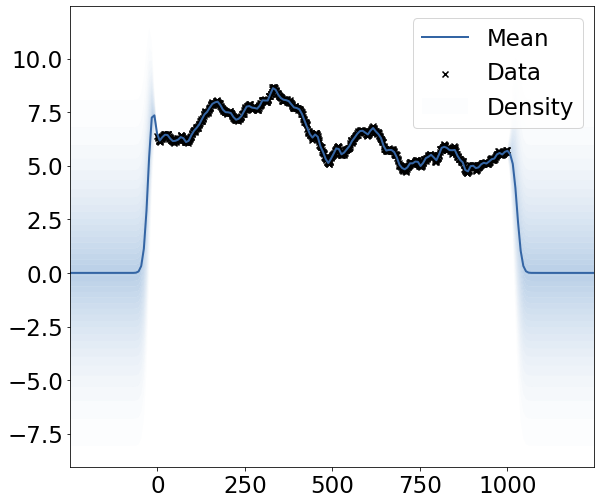

In [21]:
import GPy

# load light curve
temp = np.load("../light_curve.npz")
light_curve = temp["light_curve"]
t_array = temp["t_array"]

# extract a single light cure
X = t_array[0,:]
X = X.reshape(X.size,-1)
Y = light_curve[0,:]
Y = Y.reshape(Y.size,-1)

# define kernel
kernel = GPy.kern.RBF(input_dim=1, variance=1., lengthscale=1.)
m = GPy.models.GPRegression(X[::10],Y[::10],kernel)

# optimize
m.optimize(messages=True)
m.optimize_restarts(num_restarts = 10)

# display results
fig = m.plot(plot_density=True)
GPy.plotting.show(fig, filename='basic_gp_regression_density_notebook_optimized')

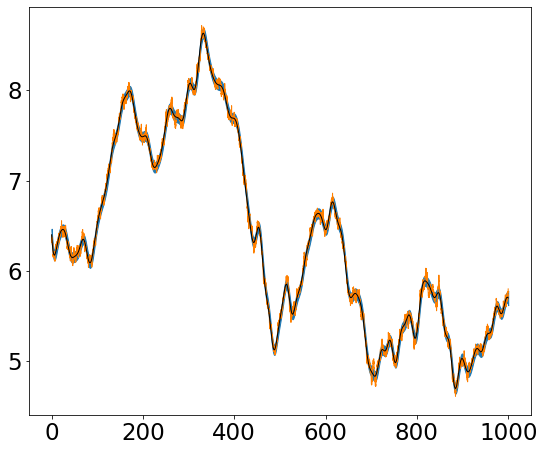

In [22]:
plt.plot(t_array[0,:],light_curve[0,:], color=cb2[1])

X_array = t_array[0,:]
X_array = X_array.reshape(X_array.size,1)

Y_predict = np.array(m.predict(X_array))[0,:,0]
Y_std = np.sqrt(np.array(m.predict(X_array))[1,:,0])

plt.plot(X_array[:,0],Y_predict, color="black")
plt.fill_between(X_array[:,0], Y_predict-Y_std, Y_predict+Y_std, color=cb2[0])